# Non-Coding (Paper-and-Pencil) Answers

## Part 1

If $X_1, \ldots, X_n$ are i.i.d. samples from a Poisson distribution with parameter $\lambda$, their joint probability (likelihood) is:
$$
L(X,\lambda) = P(X_1 = x_1, \ldots, X_n = x_n \mid \lambda) = \prod_{i=1}^n \frac{e^{-\lambda} \lambda^{x_i}}{x_i!}.
$$
Hence:
$$
L(X,\lambda) = e^{-n\lambda} \lambda^{\sum_{i=1}^n x_i} \prod_{i=1}^n \frac{1}{x_i!}.
$$

## Part 2

Suppose $\lambda \sim \Gamma(\alpha, \beta)$ with pdf:
$$
\pi(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

The posterior distribution, given the data $X$, is proportional to the prior times the likelihood:
$$
\pi(\lambda \mid X) \propto \pi(\lambda) L(X,\lambda) = \left(\frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}\right)\left(e^{-n\lambda} \lambda^{\sum_{i=1}^n x_i}\prod_{i=1}^n \frac{1}{x_i!}\right).
$$

Ignoring constants not dependent on $\lambda$, we have:
$$
\pi(\lambda \mid X) \propto \lambda^{\alpha - 1 + \sum_{i=1}^n x_i} e^{-(\beta + n)\lambda}.
$$

This is the kernel of a $\Gamma(\alpha', \beta')$ distribution where:
$$
\alpha' = \alpha + \sum_{i=1}^n x_i, \quad \beta' = \beta + n.
$$

## Part 3

We are given a prior $\Gamma(\alpha=10, \beta=1)$. We have 500 independent Poisson samples $X_1,\ldots,X_{500}$.

Let:
$$
S = \sum_{i=1}^{500} X_i.
$$

Then the posterior is:
$$
\lambda \mid X \sim \Gamma(\alpha' = 10 + S, \beta' = 1 + 500 = 501).
$$

After computing the sum $S$ from the given data, we plug it into $\alpha' = 10 + S$.

---

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func
from scipy.stats import gamma as gamma_dist

# Load the data
X = np.loadtxt('data.txt', delimiter=' ')

Sum of observed counts (S): 3938.0
Posterior alpha: 3948.0, Posterior beta: 501
Iteration 20000 completed.
Iteration 40000 completed.
Iteration 60000 completed.
Iteration 80000 completed.


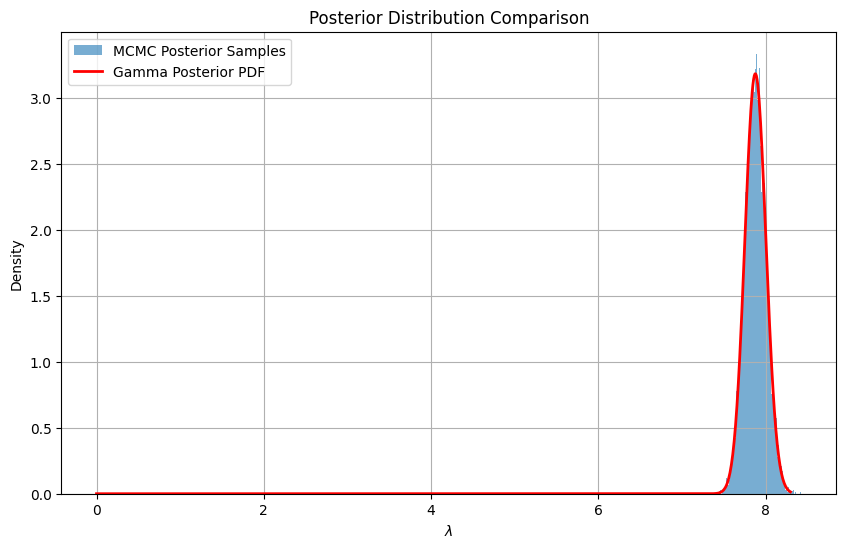

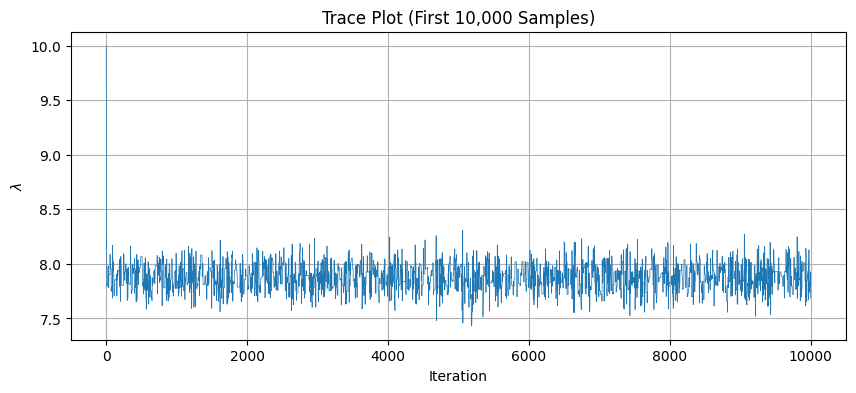

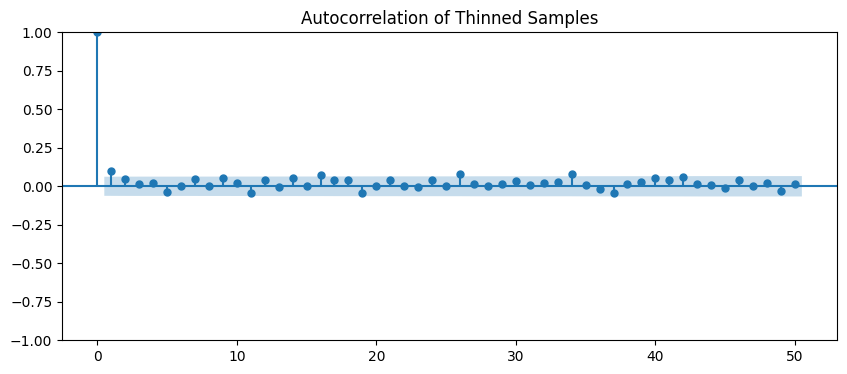

In [24]:


# Part 3: Compute updated posterior parameters
# Prior parameters
alpha_prior = 10
beta_prior = 1

# Number of samples
n = len(X)

# Sum of observed counts
S = np.sum(X)
print(f"Sum of observed counts (S): {S}")

# Updated posterior parameters
alpha_post = alpha_prior + S
beta_post = beta_prior + n
print(f"Posterior alpha: {alpha_post}, Posterior beta: {beta_post}")

# Part 4: Metropolis-Hastings MCMC for posterior sampling

# Define the log-posterior to improve numerical stability
def log_posterior(lam, alpha_p, beta_p):
    if lam <= 0:
        return -np.inf
    return (alpha_p - 1) * np.log(lam) - beta_p * lam

# Metropolis-Hastings parameters
iterations = 100000
burn_in = 5000
thinning = 10
samples = np.zeros(iterations)
samples[0] = 10.0  # starting guess

# Proposal standard deviation (tunable parameter)
proposal_std = 0.1

for i in range(1, iterations):
    current = samples[i-1]
    # Propose a new lambda using a log-normal proposal
    proposal = np.random.normal(np.log(current), proposal_std)
    lam_prop = np.exp(proposal)

    # Calculate log-posterior for current and proposed lambda
    log_p_current = log_posterior(current, alpha_post, beta_post)
    log_p_proposal = log_posterior(lam_prop, alpha_post, beta_post)

    # Calculate acceptance ratio in log-space
    log_accept_ratio = log_p_proposal - log_p_current
    accept_ratio = np.exp(log_accept_ratio)

    # Accept or reject the proposal
    if np.random.rand() < accept_ratio:
        samples[i] = lam_prop
    else:
        samples[i] = current

    # Optional: Print progress every 20,000 iterations
    if i % 20000 == 0:
        print(f"Iteration {i} completed.")

# Thinning and burn-in
thinned_samples = samples[burn_in::thinning]

# Plot histogram of samples and overlay gamma pdf
plt.figure(figsize=(10,6))
plt.hist(thinned_samples, bins=100, density=True, alpha=0.6, label="MCMC Posterior Samples")

# Define range for gamma PDF
lams = np.linspace(0, np.percentile(thinned_samples, 99.9), 1000)

# Compute gamma PDF using scipy.stats
gamma_pdf = gamma_dist.pdf(lams, a=alpha_post, scale=1.0/beta_post)

plt.plot(lams, gamma_pdf, 'r-', lw=2, label="Gamma Posterior PDF")
plt.title("Posterior Distribution Comparison")
plt.xlabel(r"$\lambda$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Trace plot to assess convergence
plt.figure(figsize=(10,4))
plt.plot(samples[:10000], lw=0.5)
plt.title("Trace Plot (First 10,000 Samples)")
plt.xlabel("Iteration")
plt.ylabel(r"$\lambda$")
plt.grid(True)
plt.show()

# Optional: Autocorrelation plot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(thinned_samples[:1000], lags=50, ax=plt.gca())
plt.title("Autocorrelation of Thinned Samples")
plt.show()
